In [1]:
# random forest  model imports and  development in progres
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from skimage.io import imread
from skimage.transform import resize


In [2]:
# 1.path  to augmented  fianl  image dataset
data_path = 'breast augmented images'
img_size = (64, 64)

X = []
y = []
class_names = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
class_indices = {cls: i for i, cls in enumerate(class_names)}
# image Preproccssing  loop
for label in class_names:
    class_dir = os.path.join(data_path, label)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        try:
            img = imread(img_path)
            img_resized = resize(img, img_size, anti_aliasing=True)
            X.append(img_resized.flatten())
            y.append(class_indices[label])
        except Exception as e:
            print(f"Failed to process image {img_path}: {e}")

X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} images with shape {X.shape[1:]} and {len(class_names)} classes.")


Loaded 12000 images with shape (12288,) and 3 classes.


In [3]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#  Reduce dimensionality with PCA (Principal Component Analysis) 
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

#  Compute class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = dict(enumerate(class_weights))
sample_weights = np.array([weight_dict[label] for label in y_train])

#  Train Random Forest
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train_pca, y_train, sample_weight=sample_weights)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [4]:
# moedl predictions
pred_labels = clf.predict(X_val_pca)
pred_probs = clf.predict_proba(X_val_pca)

# eval Metrics
acc = accuracy_score(y_val, pred_labels)
prec = precision_score(y_val, pred_labels, average='weighted')
rec = recall_score(y_val, pred_labels, average='weighted')
f1 = f1_score(y_val, pred_labels, average='weighted')

print(f"\nAccuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

try:
    roc = roc_auc_score(np.eye(len(class_names))[y_val], pred_probs, multi_class='ovr')
    print(f"ROC AUC: {roc:.3f}")
except Exception as e:
    print(f"ROC AUC not available: {e}")

print("\nClassification Report:\n", classification_report(y_val, pred_labels, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_val, pred_labels))



Accuracy: 0.582
Precision: 0.584
Recall: 0.582
F1-score: 0.582
ROC AUC: 0.752

Classification Report:
               precision    recall  f1-score   support

      benign       0.55      0.58      0.57       800
  malingnant       0.62      0.55      0.58       800
      normal       0.58      0.61      0.60       800

    accuracy                           0.58      2400
   macro avg       0.58      0.58      0.58      2400
weighted avg       0.58      0.58      0.58      2400

Confusion Matrix:
 [[465 145 190]
 [195 440 165]
 [183 126 491]]


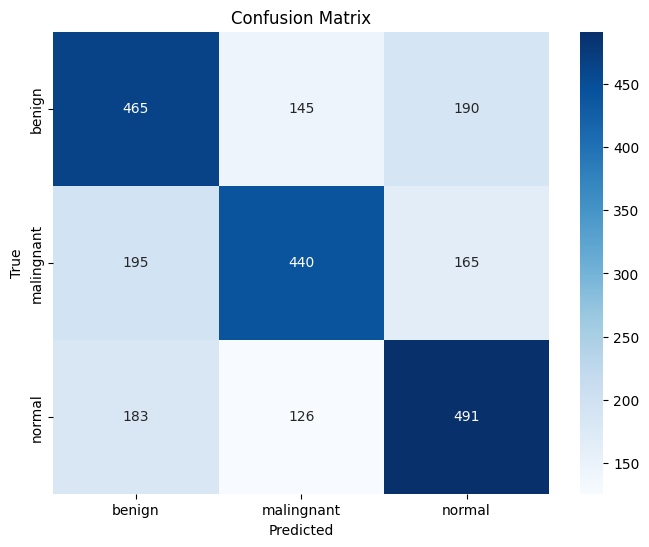

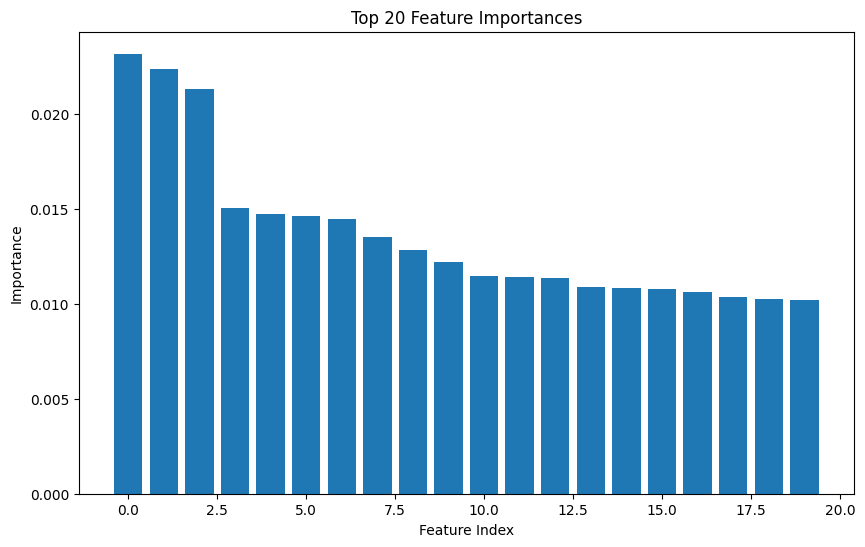

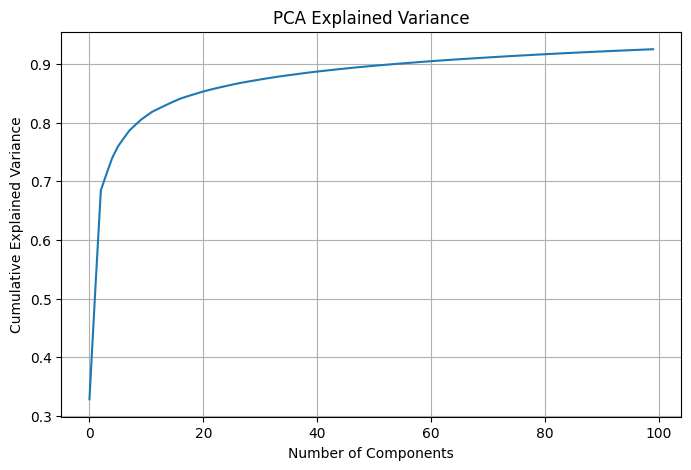

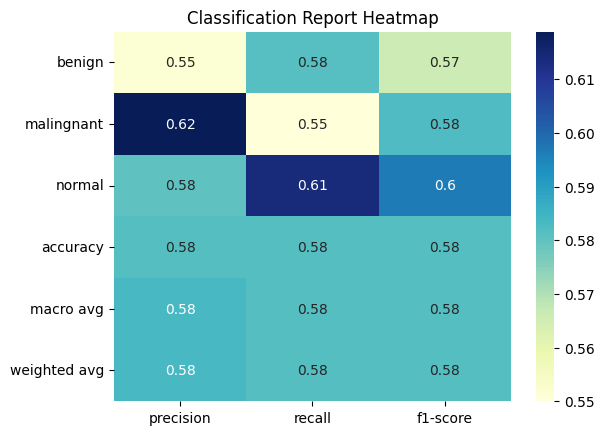

In [5]:
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, pred_labels), annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Feature importances (Top 20)
importances = clf.feature_importances_
indices = np.argsort(importances)[-20:][::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[indices])
plt.title("Top 20 Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# PCA explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Classification report heatmap
report = classification_report(y_val, pred_labels, output_dict=True, target_names=class_names)
report_df = pd.DataFrame(report).iloc[:-1, :].T
sns.heatmap(report_df, annot=True, cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.show()
